In [27]:
!pip3 install yahoo_fin

In [16]:
from yahoo_fin import stock_info
df = stock_info.get_data("^GSPC", start_date="01/01/2000", end_date="09/09/2023", index_as_date = True, interval="1d")
df = df.iloc[0:10]
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'date'})
df

,date,open,high,low,close,adjclose,volume,ticker
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,^GSPC
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,^GSPC
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,^GSPC
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,^GSPC
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,^GSPC
5,2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,^GSPC
6,2000-01-11,1457.599976,1458.660034,1434.420044,1438.560059,1438.560059,1014000000,^GSPC
7,2000-01-12,1438.560059,1442.599976,1427.079956,1432.250000,1432.250000,974600000,^GSPC
8,2000-01-13,1432.250000,1454.199951,1432.250000,1449.680054,1449.680054,1030400000,^GSPC
9,2000-01-14,1449.680054,1473.000000,1449.680054,1465.150024,1465.150024,1085900000,^GSPC


In [18]:
df['date'].apply(lambda x: DateConv.numpy_to_py(x))

NameError: name 'DateConv' is not defined

In [28]:
#from yahoo_fin.stock_info import get_data()
from yahoo_fin import stock_info
import pandas as pd

voo_daily= stock_info.get_data("^GSPC", start_date="01/01/2000", end_date="09/09/2023", index_as_date = True, interval="1d")
voo_daily.reset_index(inplace=True)
voo_daily = voo_daily.rename(columns = {'index':'date'})
voo_daily['date'] = voo_daily['date'].apply(lambda x: x.to_pydatetime().date())
voo_daily

,date,low
0,2000-01-03,1438.359985
1,2000-01-04,1397.430054
2,2000-01-05,1377.680054
3,2000-01-06,1392.099976
4,2000-01-07,1400.729980
...,...,...
5954,2023-09-01,4501.350098
5955,2023-09-05,4496.009766
5956,2023-09-06,4442.379883
5957,2023-09-07,4430.459961


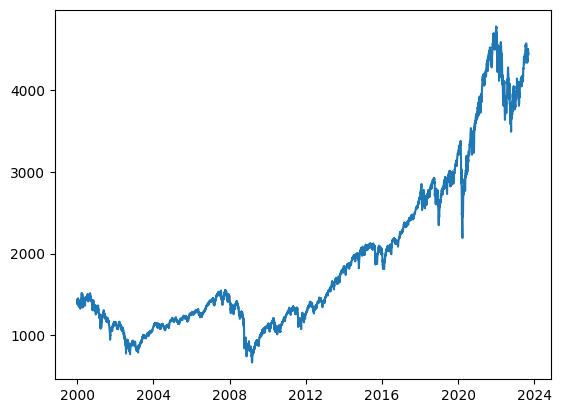

In [29]:
from matplotlib import pyplot as plt

plt.plot('date', 'low', data=voo_daily)

In [30]:
from datetime import timedelta

def next_work_date(dt, index_df):
    cur_date = dt
    while index_df[index_df['datetime'] == cur_date].empty:
        cur_date += timedelta(days=1)
    return cur_date

def prev_work_date(dt, index_df):
    cur_date = dt
    while index_df[index_df['datetime'] == cur_date].empty:
        cur_date -= timedelta(days=1)
    return cur_date

In [31]:
from datetime import date, timedelta
from calendar import mdays
import pandas as pd

voo_daily['datetime'] = voo_daily['date'].dt.date

one_day = timedelta(days=1)

montly_contribution = 1000
first_day = date.fromisoformat('2023-09-08') - timedelta(weeks=52*20)

total_contribution = 0
contributions = []
pay_date = first_day
for i in range(20*12):
    cur_pay_date = next_work_date(pay_date, voo_daily)
    total_contribution += montly_contribution
    idx_value = voo_daily[voo_daily['datetime'] == cur_pay_date]["low"].values[0]
    contributions.append((cur_pay_date, montly_contribution, montly_contribution, idx_value))
    pay_date = pay_date + timedelta(mdays[pay_date.month])

cont_df = pd.DataFrame(contributions, columns=['date', 'amount', 'adj_amount', 'idx_value'])
cont_df.head(5)

,date,amount,adj_amount,idx_value
0,2003-10-03,1000,1000,1020.239990
1,2003-11-03,1000,1000,1050.709961
2,2003-12-03,1000,1000,1064.630005
3,2004-01-05,1000,1000,1108.479980
4,2004-02-03,1000,1000,1131.329956


In [43]:
import pandas as pd
import numpy as np

from datetime import date

def compute_change(amount, then_idx_value, now_idx_value):
    change_ratio = compute_idx_change(then_idx_value, now_idx_value)
    return change_ratio * amount

def compute_idx_change(then_idx_value, now_idx_value):
    return (now_idx_value - then_idx_value) / then_idx_value

def compute_total_contributions(cont_df, summary_date):
    return np.sum(cont_df[cont_df['date'] <= summary_date]["adj_amount"])
                  
def compute_total_gains(cont_df, summary_date, cur_idx_value):
    return np.sum(cont_df[cont_df['date'] <= summary_date].apply(lambda row :
        row['adj_amount'] + compute_change(row['adj_amount'], row['idx_value'], cur_idx_value),
        axis=1
    ))

def compute_avg_idx_change(cont_df, summary_date, cur_idx_value):
    return np.mean(cont_df[cont_df['date'] <= summary_date].apply(lambda row :
        compute_idx_change(row['idx_value'], cur_idx_value),
        axis=1
    ))

year_summaries = pd.DataFrame(columns=["date", "contributions", "perc_gain", "total_value"])

for year in range(2003, 2022):
    eoy_date = date.fromisoformat(str(year)+'-12-31')
    summary_date = prev_work_date(eoy_date, voo_daily)
    idx_value = voo_daily[voo_daily['datetime'] == summary_date]["low"].values[0]
    total_gain = compute_total_gains(cont_df, summary_date, idx_value)
    total_contributions = compute_total_contributions(cont_df, summary_date)
    total_gain_perc = round((total_gain -  total_contributions) / total_contributions * 100, 2)
    year_summaries.loc[len(year_summaries)] = [summary_date, total_contributions, total_gain_perc, round(total_gain, 0)]

year_summaries

,date,contributions,perc_gain,total_value
0,2003-12-31,3000,5.87,3176.0
1,2004-12-31,15000,9.28,16391.0
2,2005-12-30,27000,8.50,29295.0
3,2006-12-29,39000,18.91,46373.0
4,2007-12-31,51000,17.54,59943.0
5,2008-12-31,63000,-28.24,45207.0
6,2009-12-31,75000,-4.79,71405.0
7,2010-12-31,87000,7.87,93848.0
8,2011-12-30,99000,7.11,106038.0
9,2012-12-31,112000,17.15,131209.0


In [141]:
import pandas as pd
import numpy as np

def f(row):
    return row['A'] < 40

df0 = pd.DataFrame({"A": [10, 20, 30, 40, 50], "B": [0, 1, 2, 3, 4]})
df1 = df0.apply(lambda row: pd.Series([row['A']+1]), axis=1)
print(df1)
df2 = df1.iloc[:(df1[0].cumsum(axis=0) <= 35).idxmin(),:]
df2 = df2.assign(B=0)
print(df2)

total = np.sum(df2[0])
if total < 35:
    last_index = df2[0].idxmax()+1
   
    remaining_amount = (35 - total)
    print(last_index, np.sum(df2[0]), remaining_amount)
    last_row = df1.iloc[last_index]
    new_adj_amount = last_row[0] - remaining_amount
    df2.loc[last_index] = [new_adj_amount, 1]
[df2.iloc[x] for x in df2.index]


    0
0  11
1  21
2  31
3  41
4  51
    0  B
0  11  0
1  21  0
2 32 3


[0    11
 B     0
 Name: 0, dtype: int64,
 0    21
 B     0
 Name: 1, dtype: int64,
 0    28
 B     1
 Name: 2, dtype: int64]

# Requirements

In [2]:
!pip3 install multipledispatch
!pip3 install python-dateutil
!pip3 install yahoo_fin

  Obtaining dependency information for multipledispatch from https://files.pythonhosted.org/packages/51/c0/00c9809d8b9346eb238a6bbd5f83e846a4ce4503da94a4c08cb7284c325b/multipledispatch-1.0.0-py3-none-any.whl.metadata
  Using cached multipledispatch-1.0.0-py3-none-any.whl.metadata (3.8 kB)
Using cached multipledispatch-1.0.0-py3-none-any.whl (12 kB)
  Using cached yahoo_fin-0.8.9.1-py3-none-any.whl (10 kB)
  Using cached requests_html-0.10.0-py3-none-any.whl (13 kB)
  Using cached feedparser-6.0.10-py3-none-any.whl (81 kB)
  Using cached sgmllib3k-1.0.0-py3-none-any.whl
  Using cached pyquery-2.0.0-py3-none-any.whl (22 kB)
  Obtaining dependency information for fake-useragent from https://files.pythonhosted.org/packages/d0/4b/1479877468e20c9a5719336a52bb0ee6f822d387b67f05a0c81e098064cc/fake_useragent-1.2.1-py3-none-any.whl.metadata
  Using cached fake_useragent-1.2.1-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for parse from https://files.pythonhosted.org/packag

In [143]:
import numpy as np
import pandas as pd

from datetime import date, timedelta
from calendar import mdays


class DateWrapper:
    def __init__(self, wrapped_date):
        self.wrapped_date = wrapped_date
        self.one_day = timedelta(days=1)
    
    def next_work_date(self, by_index):
        cur_date = self.wrapped_date
        while by_index[by_index['datetime'] == cur_date].empty:
            cur_date += self.one_day
        return DateWrapper(cur_date)
    
    def prev_work_date(self, by_index):
        cur_date = self.wrapped_date
        while by_index[by_index['datetime'] == cur_date].empty:
            cur_date -= self.one_day
        return DateWrapper(cur_date)
    
class Account:
    def __init__(self, by_index):
        self.credits = pd.DataFrame(columns=["date", "amount", "idx_value", "adj_amount"])
        self.debits = pd.DataFrame(columns=["date", "amount", "idx_value", "gains"])
        self.track_index = by_index
    
    def is_work_date(self, dt):
        return not self.track_index[self.track_index['datetime'] == dt].empty
    
    def get_idx_value(self, cur_date):
        return self.track_index[self.track_index['datetime'] == cur_date]["low"]
        
    def credit(self, cur_date, amount):
        if self.is_work_date(cur_date):
            then_idx = self.get_idx_value(cur_date)
            self.credits.loc[len(self.credits)] = [cur_date, amount, then_idx]
        else:
            raise AssertionError("not a working date")
        return self
    
    def calc_gain(self, then_idx, now_idx, amount):
        ratio = then_idx - now_idx / then_idx
        return amount * ratio
    
    def calc_balance(self, now_date):
        by_index = self.track_index
        now_work_date = DateWrapper(now_date).prev_work_date(by_index)
    
        filtered_credits = self.credits[self.credits["date"] <= now_work_date]
        filtered_debits = self.debits[self.debits["date"] <= now_work_date]
        
        total_credits = np.sum(filtered_credits["amount"])
        total_debits = np.sum(filtered_debits["amount"])
        total_contributions = total_credits - total_debits
        
        now_idx = by_index[by_index['datetime'] == now_work_date]["low"]
        gains_from_credits = np.sum(filtered_credits.apply(lambda row :
            self.calc_gain(
                row["idx_value"], 
                now_idx, 
                row["amount"]
            )
        ))
        gains_from_withdraws = np.sum(filtered_debits.apply(lambda row :
            self.calc_gain(
                row["idx_value"], 
                now_idx, 
                row["amount"]
            )
        ))
        
        total_gains = gains_from_credits
        cur_balance = total_contributions + total_gains
        return (cur_balance, total_gains, total_credits, total_debits)
    
    def source_debits(self, cur_date, debit_amount):
        filtered_credits = self.credits[self.credits["date"] <= cur_date]
        
        now_idx = self.get_idx_value(cur_date) 
        df = filtered_credits.apply(lambda row: 
            pd.Series([
                row["adj_amount"] + self.calc_gain(row["idx_value"], now_idx, row["adj_amount"])
            ])
        )
        #cummulative sum to filter credits to source the debit
        df = df.iloc[:(df[0].cumsum(axis=0) <= debit_amount).idxmin(),:]
        
        #compute new_adj_amount
        df = df.assign(new_adj_amount=0)
        debited_amount = np.sum(df[0])
        if debited_amount < debit_amount:
            last_index = df[0].idxmax()+1
            remaining_amount = (debit_amount - debited_amount)
            
            last_row = filtered_credits.iloc[last_index]
            ratio = last_row["idx_value"] - now_idx / last_row["idx_value"]
            amount_req = remaining_amount / (1 + ratio)
            withdraw_amount = remaining_amount + remaining_amount * ratio
            new_adj_amount = last_row["adj_amount"] - amount_req
            df.loc[last_index] = [withdraw_amount, new_adj_amount]
        
        return df
    
    def debit(self, cur_date, amount):
        if not self.is_work_date(cur_date):
            raise AssertionError("not a working date")
        
        then_idx = self.get_idx_value(cur_date)
        balance, _, _, _ = self.calc_balance(cur_date)
        
        if amount > balance:
            raise AssertionError("insufficient balance")
        
        withdraws = self.source_debits(cur_date, amount)
        
        gains = []
        for x in withdraws.index:
            withdrawl = withdraws.iloc[x]
            credit = self.credits.iloc[x]
            gains.append((credit["date"], withdrawl[0]-credit["adj_amount"]))
            self.credits.iloc[x]["adj_amount"] = withdrawl["new_adj_amount"]
            
        self.debits.loc[len(self.debits)] = [cur_date, amount, then_idx, gains]
        return self


class AccountBuilder:
    def __init__(self, first_day, by_index):
        self.first_day = by_index
        self.by_index = by_index
        self.account = Account(by_index)
    
    def credit_monthly(self, amount, last_date):
        pay_date = self.first_day
        while pay_date <= last_date:
            cur_pay_date = DateWrapper(pay_date).next_work_date(self.by_index)
            self.account.credit(cur_pay_date, amount)
            pay_date = pay_date + timedelta(mdays[pay_date.month])
        return self
    
    def withdraw_amounts(self, withdrawls):
        for (year, amount) in withdrawls:
            dt = date.fromisoformat(str(year)+'-12-31')
            cur_pay_date = DateWrapper(dt).prev_work_date(self.by_index)
            self.account.debit(cur_pay_date, amount)
        return self

In [ ]:
import pandas as pd

last_day = date.fromisoformat('2023-09-08')
first_day = date.fromisoformat('2023-09-08') - timedelta(weeks=52*20)
montly_contribution = 1000
withdraws = [(2003+15, 40000), (2003+16, 40000), (2003+17, 40000), (2003+18, 40000)]

account_builder = AccountBuilder(first_day, voo_daily)
account_builder.credit_monthly(montly_contribution, last_day)
account_builder.withdraw_amounts(withdraws)
account  = account_builder.account

year_summaries_wd = pd.DataFrame(columns=["date", "contributions", "withdrawls", "perc_gain", "total_value"])
for year in range(2003, 2022):
    eoy_date = date.fromisoformat(str(year)+'-12-31')
    summary_date = prev_work_date(eoy_date, voo_daily)
    idx_value = voo_daily[voo_daily['datetime'] == summary_date]["low"].values[0]
    total_gain = compute_total_gains(cont_df, summary_date, idx_value)
    total_contributions = compute_total_contributions(cont_df, summary_date)
    total_gain_perc = round((total_gain -  total_contributions) / total_contributions * 100, 2)
    year_summaries.loc[len(year_summaries)] = [summary_date, total_contributions, total_gain_perc, round(total_gain, 0)]
